In [45]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
import jieba
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import stopwordsiso as stopwords
from scipy.stats import ttest_ind, f_oneway
from transformers import pipeline

In [2]:
df = pd.read_csv('output.csv', encoding='utf-8')

In [1]:
# Function to load and structure the data
def load_corpus(corpus_path):
    data = []
    for leader in ['mao', 'xi']:
        leader_path = Path(os.path.join(corpus_path, leader))
        for file in leader_path.glob("*.txt"):
            date_str = file.stem.split('-')  # Extract date from filename
            date = pd.to_datetime('-'.join(date_str), format="%d-%m-%Y")
            with open(file, 'r', encoding='utf-8') as f:
                text = f.read()
            data.append({'leader': leader, 'date': date, 'year': date.year, 'text': text})
    return pd.DataFrame(data)

# Load the corpus
corpus_path = os.path.relpath(r'..\corpus')
df = load_corpus(corpus_path)

In [2]:
# Tokenize text using jieba
df['tokens'] = df['text'].apply(jieba.lcut)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\yancu\AppData\Local\Temp\jieba.cache
Loading model cost 0.837 seconds.
Prefix dict has been built successfully.


In [3]:
# Defining modality markers for deontonic and epistamic modalities.
# Modality instensities are further categorized into low, medium, and high.
# This correpsponds to 可能性，盖然性，必然性.

emm_low = ['或许', '或者', '兴许', '也许', '大概', '许', '大约', '约', '约莫', '仿佛', '好像', '俨然', '似乎', '横是', '难免', '保不齐', '保不住', '不定', '难道', '别是', '敢是', '莫非', '岂', '别不是', '莫不是']
emm_med = ['没准', '没准儿', '多半', '大多', '至多', '至少', '大半', '差点', '八成', '八成儿', '差一点', '几乎', '差不多', '大抵', '起码', '想必', '看来', '怕是', '恐怕', '未免', '不免', '不愧', '难怪', '怪不得', '怨不得']
emm_high = ['肯定', '必然', '必定', '必将', '必', '定', '确', '诚', '准', '真', '的确', '确实', '确乎', '无非', '准保', '保管', '管保', '委实', '诚然', '断然', '定然', '势必', '无疑', '一准', '一准儿', '硬是', '实在', '着实', '决计', '倒', '倒是', '当然', '显然', '本', '本来', '原本', '固', '压根', '压根儿', '总', '只管', '尽管', '毕竟', '总归', '究竟', '终究', '终归', '其实', '到底', '实际', '实际上', '居然', '竟然', '竟', '竟自', '反倒', '反而', '反', '果然', '果真', '果不其然', '原来', '敢情', '简直', '明明', '分明', '就是', '偏', '偏偏', '死活', '横竖', '高低', '宁可', '宁肯', '宁愿', '宁', '毋宁', '反正', '左右', '好歹', '索性', '干脆']

dmm_med = ['最好', '不妨', '无妨', '何苦', '何妨', '何不']
dmm_high = ['必须', '务必', '必得', '非', '非得', '只好', '只得', '决', '绝', '绝对', '断', '断断', '断乎', '切', '切切', '千万', '万', '万万', '何必']

marker_dict = {
    'emm_low': emm_low,
    'emm_med': emm_med,
    'emm_high': emm_high,
    'dmm_med': dmm_med,
    'dmm_high': dmm_high
}

Counting EMMs

In [4]:
def count_emms(tokens, emms):
    token_counts = Counter(tokens)
    return {emm: token_counts.get(emm, 0) for emm in emms}

# Apply counting

for marker_type in marker_dict:
    df[marker_type] = df['tokens'].apply(lambda tokens: sum(count_emms(tokens, marker_dict[marker_type]).values()))

In [5]:
# Sum EMMs and DMMs
df['total_emms'] = df[['emm_low', 'emm_med', 'emm_high']].sum(axis=1)
df['total_dmms'] = df[['dmm_med', 'dmm_high']].sum(axis=1)

# Calculate weighted sums
df['weighted_emms'] = df['emm_low'] * 1 + df['emm_med'] * 2 + df['emm_high'] * 3
df['weighted_dmms'] = df['dmm_med'] * 2 + df['dmm_high'] * 3

\# Aggregating Data for Time Period Analysis

In [6]:
# # Sum EMM counts for each year and leader
# yearly_data = df.groupby(['leader', 'year'])['emm_counts'].apply(
#     lambda x: sum((Counter(c) for c in x), Counter())
# ).reset_index()

# # Expand the aggregated EMM counts into separate columns
# yearly_df = pd.DataFrame(yearly_data['emm_counts'].tolist(), index=yearly_data.index)
# yearly_data = pd.concat([yearly_data, yearly_df], axis=1).drop(columns=['emm_counts'])


Normalise Marker Counts

In [61]:
normalise_columns =  ['emm_low', 'emm_med', 'emm_high', 'dmm_med', 'dmm_high', 'total_emms', 'total_dmms', 'weighted_emms', 'weighted_dmms']

# Compute total token count per text
df['total_tokens'] = df['tokens'].apply(len)

# Normalize marker counts (per 1,000 tokens)
for marker_type in normalise_columns:
    df[marker_type + '/1000tok'] = (df[marker_type] / df['total_tokens']) * 1000

Aggregate by Time Period

In [31]:
agg_columns = ['emm_low/1000tok', 'emm_med/1000tok', 'emm_high/1000tok',
               'dmm_med/1000tok', 'dmm_high/1000tok',
               'total_emms/1000tok', 'total_dmms/1000tok',
               'weighted_emms/1000tok', 'weighted_dmms/1000tok']

# Extract year from the date
df['year'] = df['date'].dt.year

AttributeError: Can only use .dt accessor with datetimelike values

In [63]:
agg_columns = ['emm_low/1000tok', 'emm_med/1000tok', 'emm_high/1000tok',
               'dmm_med/1000tok', 'dmm_high/1000tok',
               'total_emms/1000tok', 'total_dmms/1000tok',
               'weighted_emms/1000tok', 'weighted_dmms/1000tok', 'total_tokens']

# Group by year and aggregate
marker_list = [marker_type for marker_type in agg_columns]
yearly_stats = df.groupby(['year', 'leader'])[agg_columns].mean().reset_index()

# # Introduce NaN for missing years
# full_years = pd.DataFrame({'year': range(yearly_stats['year'].min(), yearly_stats['year'].max())})
# yearly_stats = pd.merge(full_years, yearly_stats, on='year', how='left')

In [9]:
leader_totals = df.groupby('leader').sum()

In [11]:
total_tokens_by_leader = df.groupby('leader')['total_tokens'].sum()
print(total_tokens_by_leader)

leader
mao    697516
xi     478169
Name: total_tokens, dtype: int64


In [13]:
leader_means = df.groupby('leader').mean(numeric_only=True)

In [18]:
plotted_columns = ['emm_low/1000tok', 'emm_med/1000tok', 'emm_high/1000tok', 'total_emms/1000tok']

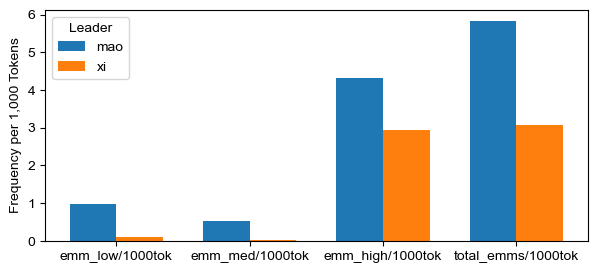

In [28]:
# Extract the means for each leader and plotted column
leader_means_subset = leader_means[plotted_columns].reset_index()

# Set the font to Arial
plt.rcParams['font.family'] = 'Arial'

# Set the positions and width for the bars
bar_width = 0.35
positions = range(len(plotted_columns))

# Create the bar chart
fig, ax = plt.subplots(figsize=(7, 3))

# Plot bars for each leader
for i, leader in enumerate(leader_means_subset['leader']):
    ax.bar([p + bar_width * i for p in positions], leader_means_subset.loc[i, plotted_columns], bar_width, label=leader)

# Set the x-axis labels and positions
ax.set_xticks([p + bar_width / 2 for p in positions])
ax.set_xticklabels(plotted_columns)

# Add labels and title

ax.set_ylabel('Frequency per 1,000 Tokens')
# ax.set_title('Comparison of Marker Usage Between Leaders')
ax.legend(title='Leader')

# Show the plot
plt.show()

Plotting

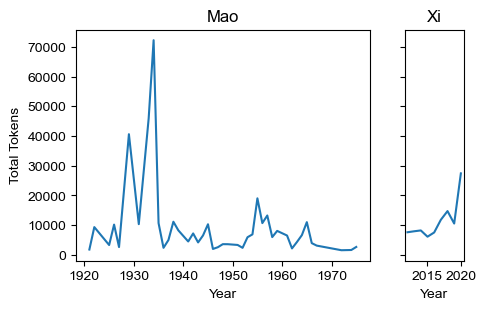

In [68]:
# Set the font to Arial
plt.rcParams['font.family'] = 'Arial'

# Define the time periods
period1 = yearly_stats[(yearly_stats['year'] >= 1921) & (yearly_stats['year'] <= 1975)]
period2 = yearly_stats[(yearly_stats['year'] >= 2012) & (yearly_stats['year'] <= 2020)]

# Create subplots with different width ratios
fig, axes = plt.subplots(1, 2, figsize=(5, 3), sharey=True, gridspec_kw={'width_ratios': [5, 1]})

# Plot total tokens for the first period (1921 - 1975)
sns.lineplot(data=period1, x='year', y='total_tokens', ax=axes[0])
axes[0].set_title('Mao')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Total Tokens')

# Plot total tokens for the second period (2012 - 2020)
sns.lineplot(data=period2, x='year', y='total_tokens', ax=axes[1])
axes[1].set_title('Xi')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('')

# Set the overall title and show the plot
# fig.suptitle('Total Tokens Over Years')
plt.show()

In [9]:
plotted_columns = ['total_emms/1000tok', 'total_dmms/1000tok', 'weighted_emms/1000tok', 'weighted_dmms/1000tok']

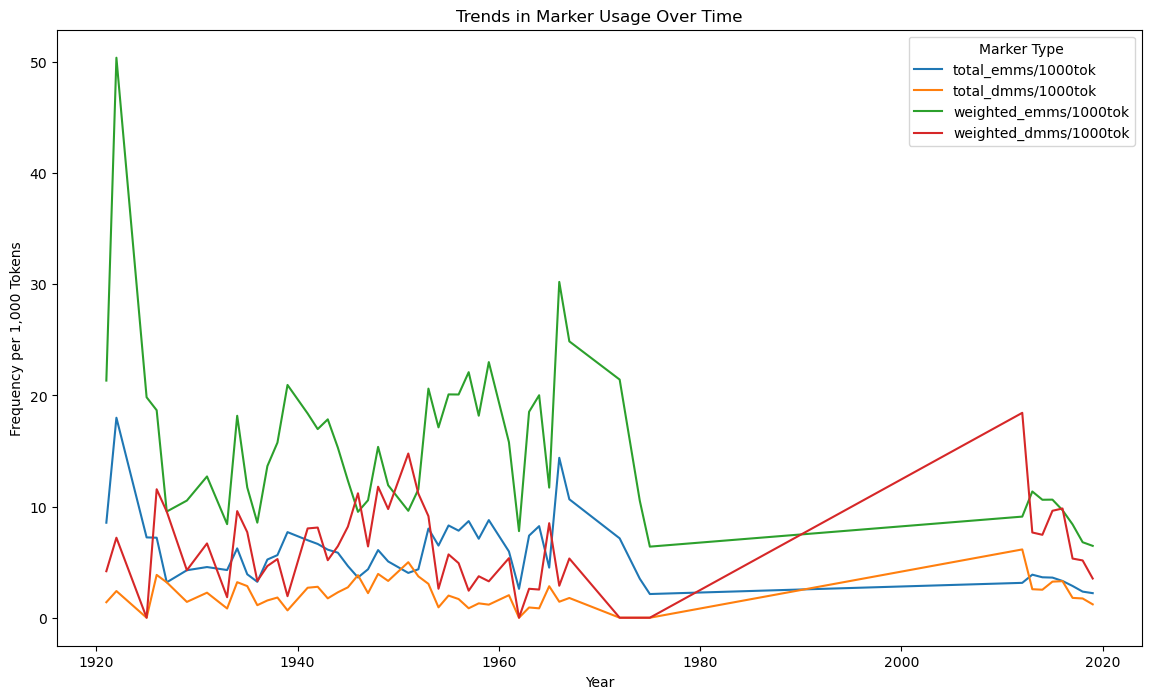

In [10]:
# Plot each marker type's trend over years
plt.figure(figsize=(14, 8))
for marker_type in plotted_columns:
    sns.lineplot(data=yearly_stats, x='year', y=marker_type, label=marker_type)

plt.title('Trends in Marker Usage Over Time')
plt.xlabel('Year')
plt.ylabel('Frequency per 1,000 Tokens')
plt.legend(title='Marker Type')
plt.show()

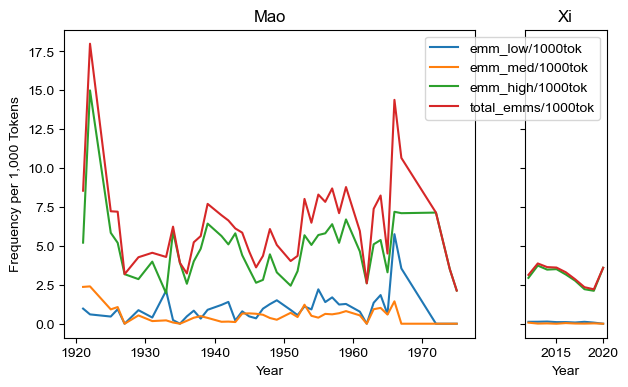

In [41]:
plt.rcParams['font.family'] = 'Arial'
# Define the time periods
period1 = yearly_stats[(yearly_stats['year'] >= 1921) & (yearly_stats['year'] <= 1975)]
period2 = yearly_stats[(yearly_stats['year'] >= 2012) & (yearly_stats['year'] <= 2020)]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(7, 4), sharey=True, gridspec_kw={'width_ratios': [5, 1]})

# Plot for the first period (1921 - 1975)
for marker_type in plotted_columns:
    sns.lineplot(data=period1, x='year', y=marker_type, ax=axes[0])

axes[0].set_title('Mao')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Frequency per 1,000 Tokens')

# Plot for the second period (2012 - 2020)
for marker_type in plotted_columns:
    sns.lineplot(data=period2, x='year', y=marker_type, ax=axes[1], label=marker_type)

axes[1].set_title('Xi')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('')

# Set the overall title and show the plot
# fig.suptitle('Trends in Marker Usage Over Time')
# plt.legend(title='Marker Type')
plt.show()

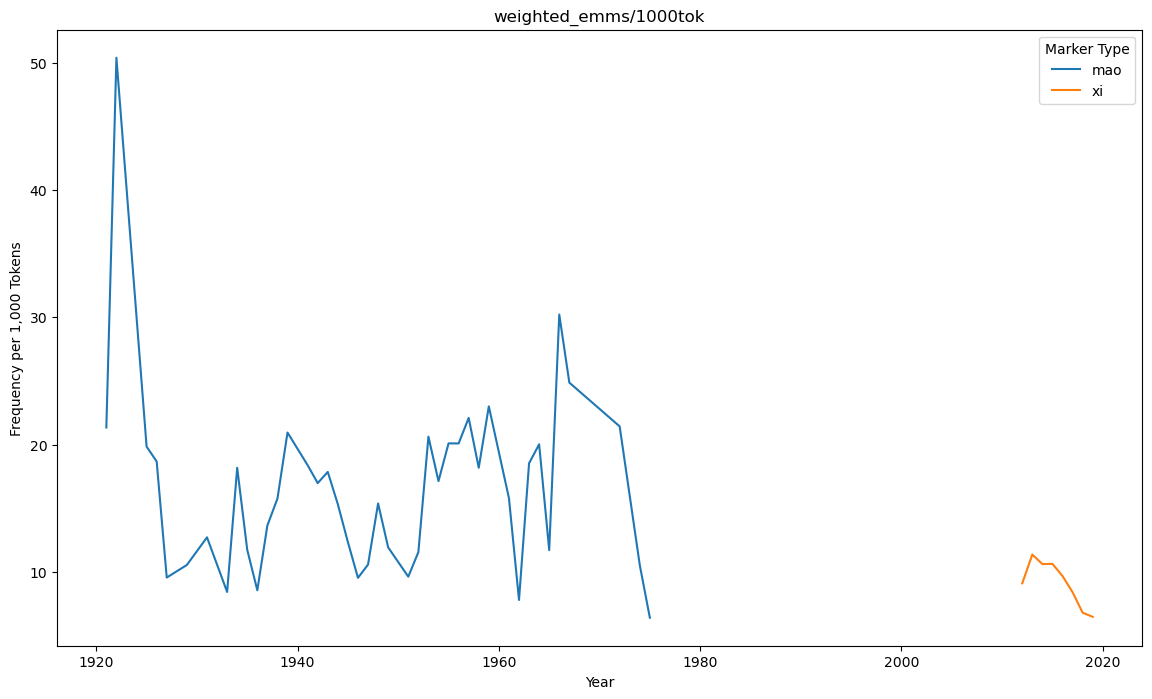

In [11]:
# weighted_emms/1000tok
plt.figure(figsize=(14, 8))
sns.lineplot(data=yearly_stats, x='year', y='weighted_emms/1000tok', hue='leader')

plt.title('weighted_emms/1000tok')
plt.xlabel('Year')
plt.ylabel('Frequency per 1,000 Tokens')
plt.legend(title='Marker Type')
plt.show()

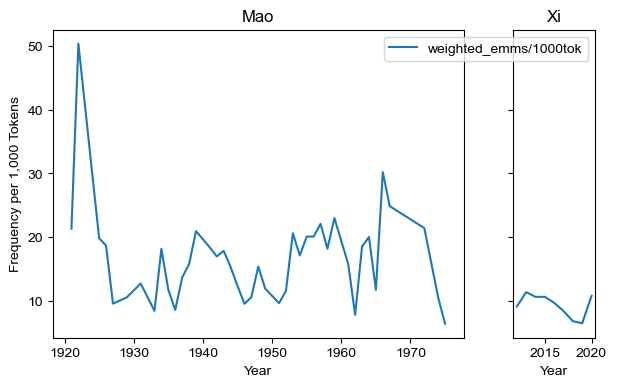

In [43]:
plt.rcParams['font.family'] = 'Arial'
# Define the time periods
period1 = yearly_stats[(yearly_stats['year'] >= 1921) & (yearly_stats['year'] <= 1975)]
period2 = yearly_stats[(yearly_stats['year'] >= 2012) & (yearly_stats['year'] <= 2020)]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(7, 4), sharey=True, gridspec_kw={'width_ratios': [5, 1]})

# Plot for the first period (1921 - 1975)
sns.lineplot(data=period1, x='year', y='weighted_emms/1000tok', ax=axes[0])

axes[0].set_title('Mao')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Frequency per 1,000 Tokens')

# Plot for the second period (2012 - 2020)
sns.lineplot(data=period2, x='year', y='weighted_emms/1000tok', ax=axes[1], label='weighted_emms/1000tok')

axes[1].set_title('Xi')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('')

# Set the overall title and show the plot
# fig.suptitle('Trends in Marker Usage Over Time')
# plt.legend(title='Marker Type')
plt.show()

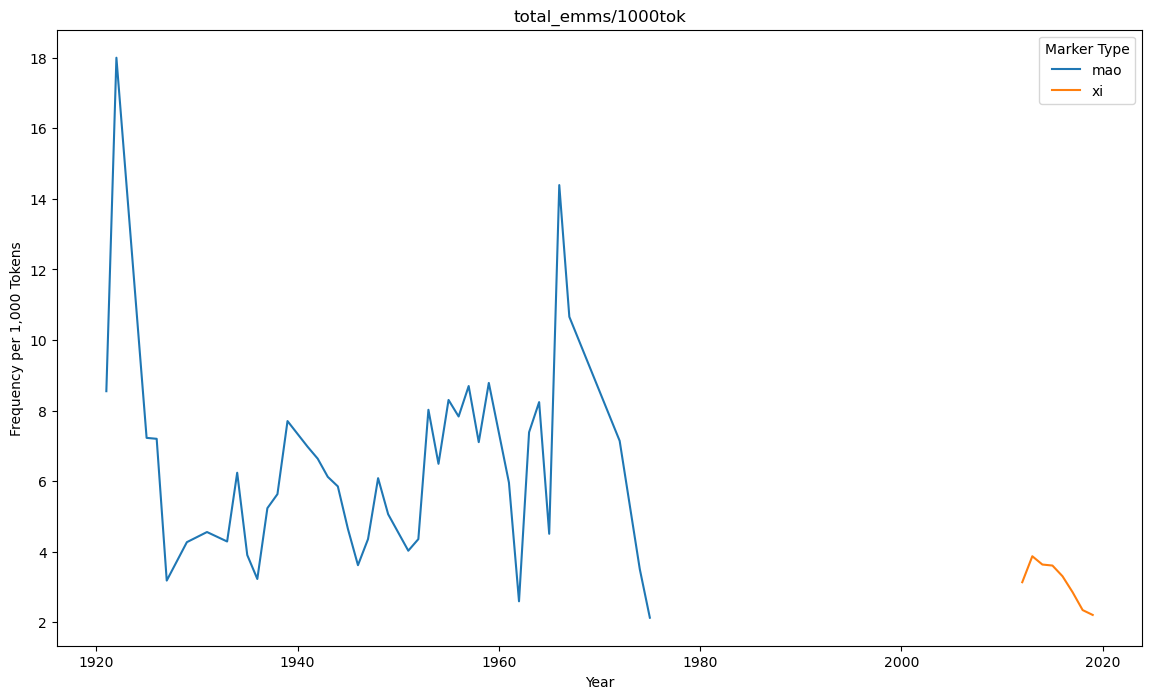

In [12]:
# total_emms/1000tok
plt.figure(figsize=(14, 8))
sns.lineplot(data=yearly_stats, x='year', y='total_emms/1000tok', hue='leader')

plt.title('total_emms/1000tok')
plt.xlabel('Year')
plt.ylabel('Frequency per 1,000 Tokens')
plt.legend(title='Marker Type')
plt.show()

Correlation with context

In [13]:
# Vectorize text data
vectorizer = TfidfVectorizer(max_features=1000, stop_words=list(stopwords.stopwords("zh")))
tfidf_matrix = vectorizer.fit_transform(df['text'])

# Apply topic modeling
nmf = NMF(n_components=5, random_state=42)
topic_matrix = nmf.fit_transform(tfidf_matrix)

# Assign dominant topic to each text
df['topic'] = topic_matrix.argmax(axis=1)


In [14]:
topic_stats = df.groupby(['topic', 'leader'])[agg_columns].mean().reset_index()

Statistical Analysis

In [56]:
plotted_columns = ['emm_low/1000tok', 'emm_med/1000tok', 'emm_high/1000tok', 'total_emms/1000tok', 'weighted_emms/1000tok']

# independent t-test

for marker in plotted_columns:
    mao_data = df[df['leader'] == 'mao'][marker]
    xi_data = df[df['leader'] == 'xi'][marker]
    t_stat, p_value = ttest_ind(mao_data, xi_data)
    print(f'T-test for {marker}: t={t_stat}, p={p_value}')

T-test for emm_low/1000tok: t=8.564176257459097, p=4.539834005506906e-17
T-test for emm_med/1000tok: t=7.077271685108137, p=2.9163997381591363e-12
T-test for emm_high/1000tok: t=5.262793941976094, p=1.7665871871093757e-07
T-test for total_emms/1000tok: t=9.096237158206863, p=5.660236527929184e-19
T-test for weighted_emms/1000tok: t=7.332525071808368, p=4.952663942635815e-13


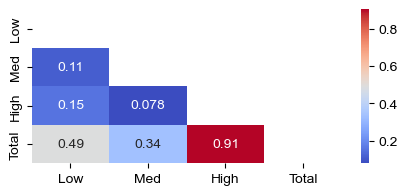

In [55]:
# Define the columns to include in the correlation matrix
corr_columns = ['emm_low/1000tok', 'emm_med/1000tok', 'emm_high/1000tok', 'total_emms/1000tok']

# Create a dictionary to map original column names to shortened names
shortened_names = {
    'emm_low/1000tok': 'Low',
    'emm_med/1000tok': 'Med',
    'emm_high/1000tok': 'High',
    'total_emms/1000tok': 'Total'
}

# Rename the columns in the DataFrame
df_shortened = df[corr_columns].rename(columns=shortened_names)

# Calculate the correlation matrix
correlation_matrix = df_shortened.corr()

# Create a heatmap with a smaller figure size
plt.figure(figsize=(5, 2))  # Adjust the figsize to make it smaller
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=np.triu(correlation_matrix))

plt.show()

Qualitative Analysis

In [59]:
top_emms = df.nlargest(20, 'total_emms/1000tok')
top_high_emms = df.nlargest(20, 'emm_high/1000tok')

In [22]:
# Load a pre-trained sentiment analysis model for Chinese
sentiment_analysis = pipeline("sentiment-analysis", model="uer/roberta-base-finetuned-jd-binary-chinese")

def analyze_sentiment(text):
    # Truncate or pad the text to the maximum sequence length (512 tokens)
    return sentiment_analysis(text, truncation=True, max_length=512)

# Analyze sentiment
df['sentiment'] = df['text'].apply(lambda x: analyze_sentiment(x))

In [23]:
df.to_csv('output.csv', index=False, encoding='utf-8')

In [6]:
df[df['leader'] == 'xi']['year'].min()

2012